## Dependencies

In [ ]:
!pip install git+https://github.com/huggingface/diffusers.git
!pip install torchvision
!pip install transformers>=4.25.1
!pip install datasets
!pip install timm

from transformers import AutoModelForCausalLM, AutoTokenizer
from diffusers import StableDiffusionPipeline
from datasets import load_dataset, Image
import torch
import timm

from google.colab import drive
drive.mount('/content/drive')

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-99s2s_wn
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-99s2s_wn
  Resolved https://github.com/huggingface/diffusers.git to commit 235d34cf567e78bf958344d3132bb018a8580295
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.28.0.dev0-py3-none-any.whl size=2095762 sha256=9c9fd8fa34f09d1c6574e0ad130cc30a7e95ac889ed0cf97aa833fe32353973c
  Stored in directory: /tmp/pip-ephem-wheel-cache-8xzmee46/wheels/4d/b7/a8/6f9549ceec5daad78675b857ac57d697c387062506520a7b50
Successfully built diffusers
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-p

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Mounted at /content/drive


In [ ]:
!huggingface-cli login

## Data Preparation

In [ ]:
import os
#import fiftyone
from pycocotools.coco import COCO
import json
from PIL import Image


#sys.path.append('/opt/cocoapi/PythonAPI')

# https://github.com/L1aoXingyu/image-caption-project/blob/master/0_Dataset.ipynb
# returns a COCO object(which is dataset to be sampled from), coco_caps(captions), and the ids for COCO data instances
def load_coco():
    # initialize COCO API for instance annotations
    dataDir = '/content/gdrive/My Drive/cocoapi'
    dataType = 'val2014'
    instances_annFile = os.path.join(dataDir, 'annotations/instances_{}.json'.format(dataType))
    coco = COCO(instances_annFile)

    # initialize COCO API for caption annotations
    captions_annFile = os.path.join(dataDir, 'annotations/captions_{}.json'.format(dataType))
    coco_caps = COCO(captions_annFile)

    # get image ids
    ids = list(coco.anns.keys())
    return coco, coco_caps, ids


def sample_image(coco, coco_caps, ids, count):
    images = []
    captions = []
    while count > 0:
      count -= 1
      # pick a random image and obtain the corresponding URL
      ann_id = np.random.choice(ids)
      print(f"ann_id: {ann_id}")
      img_id = coco.anns[ann_id]['image_id']
      img = coco.loadImgs(img_id)[0]
      url = img['coco_url']

    # print URL and visualize corresponding image
    #print(url)
    #I = io.imread(url)
    #plt.axis('off')
    #plt.imshow(I)
    #plt.show()

    # load and display captions
      annIds = coco_caps.getAnnIds(imgIds=img['id']);
      anns = coco_caps.loadAnns(annIds)
      #coco_caps.showAnns(anns)
      images.append(img)
      captions.append(anns)
    return images, captions

# mistral for text generation
device = "cuda"
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
model.to(device)

# generate instructions for LLM, feed into LLM, get optimized prompts
# few shot prompting: type/color of object, posture of object, place of object, placement relationship between objects, "invent" related unmentioned things!
def improve_captions(captions):
    improved_captions  = []
    for cap in captions:
        text = f'''[INST] ### Instructions:
You will be given a set of short prompts that is used for image generation. Your task is to generate a better detailed prompt based on the given prompt.
A few things you can do:

1. If there is an object, try to describe the color/type of the object.
For example, it the prompt contains "a cat", change it to "an orange Siamese cat".
Do a random choice if no more information of the object is provided.

2. If there is a creature, describe the posture, action and expression of the creature, if possible.
For example, it the prompt contains "a cat", add descriptions like "the cat is lying on the floor" or "the cat is running" .
For example, for a prompt involving a person, you might add "the person is smiling warmly".
Do a random choice if no more information of the creature is provided.

3. Describe spatial relationship between objects.
For example, if the prompt contains two objects, "a cat" and "a dog", add descriptions like "a cat is sitting next to the dog".
Describe the place of the objects.
For example, if  the prompt contains "two cats", describe the place of the cat like "one cat is sitting on the table next to the dog, and another cat is lying on the floor."

4. Include Atmospheric Details and Consider Lighting and Time of Day.
For example, "the scene is enveloped in a misty morning atmosphere." or "a cat sitting next to a dog in the soft glow of sunset."

5. Add background elements.
Add one or two things that is not mentioned in the prompt, but is related to the subject of the prompt, complementing the main subjects to provide context.
For example, if the prompt is "pizza on a plate", you can add "with a wine glass on the side"
because they are related items that could appear on a dining table.
Ensure the additions are contextually appropriate and enhance the central theme of the prompt.

6. Revise the whole prompt and word edit if necessary.
Ensure the final prompt is grammatically coherent and syntactically clear, as complex constructions might confuse the image generation model.
Limit each prompt to 50 words.

The original caption is: {cap}
[/INST]

The improved caption is: '''
        inputs = tokenizer(text, return_tensors="pt").to(device)
        outputs = model.generate(**inputs, max_new_tokens=(100))
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        # print(response)
        improved_captions.append(response[len(text):])
    return improved_captions

def load_from_local():
    image_folder = '/content/drive/My Drive/C5470prj/coco_subset'
    file_path = image_folder + '/captions_with_improved.json'
    with open(file_path, 'r') as file:
        data = json.load(file)
    ids = []
    images = []
    captions = []
    improved_captions = []
    data = sorted(data, key=lambda x: x['image_id'])
    for item in data:
        ids.append(item['image_id'])
        captions.append(item['caption'])
        improved_captions.append(item['improved_caption'])
        image_id = item['image_id']
        filename = f'{image_id:012d}.jpg' # 12 digit padding
        full_path = os.path.join(image_folder, filename)
        try:
            img = Image.open(full_path)
            images.append(img)
        except FileNotFoundError:
            print(f"Image file not found: {full_path}")
    return ids, images, captions, improved_captions


## Inference: first pass

inference on InstanceDiffusion runs separately on our local machines.

In [ ]:
# load pretrianed StableDiffusion
model_path = "runwayml/stable-diffusion-v1-5"
device = "cuda"
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16)
pipe.to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.28.0.dev0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
#coco, coco_caps, ids = load_coco()
#images, captions = sample_images(coco, coco_caps, ids, 1)
#improved_catpions = improve_captions(captions)

ids, images, captions, improved_captions = load_from_local()

improved_images = []
improved_folder = '/content/drive/My Drive/C5470prj/improved_images'

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

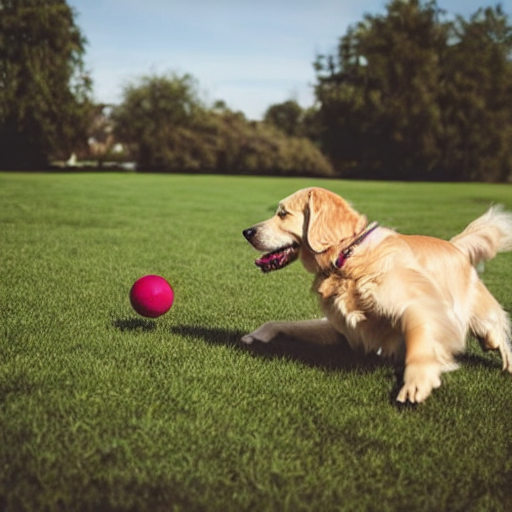

In [ ]:


# model inference with different prompting
for i, (id, caption, improved_caption) in enumerate(zip(ids, captions, improved_captions)):
    # normal caption
    # original_image = pipe(prompt=caption).images[0] # no need for now!
    # improved caption
    improved_image = pipe(prompt=improved_caption).images[0]
    improved_images.append(improved_image)
    improved_image.save(improved_folder + f"/{id}.png")

image = pipe(prompt="a golden retriever playing with a ball").images[0]
image

## Evaluation

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
import clip
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.3 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ty3zcz2y
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ty3zcz2y
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369499 sha256=64c7ea15716feb54a2078a9a980fbe309f8a4b38565e6cf496c0823e9f66b017
  Stored in directory: /tmp/pip-ephem-wheel-cache-sh3rq1tb/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
import numpy as np
clip_model, preprocess = clip.load("ViT-B/32")
clip_model.to(device)
clip_model.eval()
input_resolution = clip_model.visual.input_resolution
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print(f"Model parameters: {np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 148MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
from IPython.display import display
def calculate_clip_scores(model, preprocess, images, captions):
    image_features = []
    for image in images:
        image_processed = preprocess(image).unsqueeze(0).to(device)
        image_features.append(model.encode_image(image_processed))
        display(image)

    print(captions)

    text_tokens = clip.tokenize(captions).to(device)
    text_features = model.encode_text(text_tokens)

    image_features = torch.cat(image_features)
    similarity = torch.matmul(image_features, text_features.t()).diag().cpu().detach().numpy()
    return similarity

def print_stats(improved_images, captions, improved_scores):
    # show prompt-image pairs with highest/lowest score
    paired_scores = list(zip(improved_images, captions, improved_scores))
    paired_scores.sort(key=lambda x: x[2], reverse=True)

    img, cap, sc = paired_scores[0]
    print(f"Highest CLIP Score: {sc}, caption: {cap}, img: ")
    display(img)
    img, cap, sc = paired_scores[-1]
    print(f"Lowest CLIP Score: {sc}, caption: {cap}, img: ")
    display(img)



In [ ]:
# calculate CLIP-SCORE
improved_scores = calculate_clip_scores(clip_model, preprocess, improved_images, captions)
original_scores = calculate_clip_scores(clip_model, preprocess, images, captions)

print(f"original avg score: {np.average(original_scores)}")
print_stats(images, captions, original_scores)

print(f"imrpoved avg score: {np.average(improved_scores)}")
print_stats(improved_images, captions, improved_scores)




original avg score: 22.125
imrpoved avg score: 25.828125

In [ ]:
# fid , if time:
# https://huggingface.co/docs/diffusers/v0.21.0/conceptual/evaluation#imageconditioned-texttoimage-generation


## Tuning, and evaluate again
training was ran on local instead.

In [ ]:
!pip install ftfy
!pip install tensorboard
!pip install Jinja2
!pip install peft==0.7.0
!pip install accelerate>=0.16.0

!accelerate config
# : train the model on improved captions-image pair, and generate again

improved_images, improved_captions

# train
# https://huggingface.co/docs/diffusers/v0.13.0/en/training/text2image
# https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image_flax.py


!export MODEL_NAME="runwayml/stable-diffusion-v1-5"
!export dataset_name="TODO"

!python train_text_to_image_flax.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --dataset_name=$dataset_name \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=1 \
  --max_train_steps=15000 \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --output_dir="TODO"

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import random
import fnmatch

def load_and_sort(folder_path):
    images = []
    files = sorted(os.listdir(folder_path))
    for id in ids:
        patterns = [f'*{id}*.jpg', f'*{id}*.png']
        for file in files:
            if any(fnmatch.fnmatch(file, pattern) for pattern in patterns):
                images.append(Image.open(os.path.join(folder_path, file)))
                break
    return images

folder_paths = {
    'improved_caption': '/content/drive/My Drive/C5470prj/improved_caption',
    'improved_images': '/content/drive/My Drive/C5470prj/improved_images',
    'original_caption': '/content/drive/My Drive/C5470prj/original_caption'
}

improved_caption_images = load_and_sort(folder_paths['improved_caption'])
improved_images = load_and_sort(folder_paths['improved_images'])
original_caption_images = load_and_sort(folder_paths['original_caption'])

for i, (image1, image2, image3) in enumerate(zip(improved_images, original_caption_images, improved_caption_images)):
    #print(image1)
    base_width = 300
    image1 = image1.resize((base_width, int(base_width * image1.height / image1.width)))
    image2 = image2.resize((base_width, int(base_width * image2.height / image2.width)))
    image3 = image3.resize((base_width, int(base_width * image3.height / image3.width)))

    total_width = base_width * 3
    max_height = max(image1.height, image2.height, image3.height) + 50  # 50 pixels for labels
    combined_image = Image.new('RGB', (total_width, max_height), (255, 255, 255))

    # shuffle for questionnaire
    images_list = list((image1, image2, image3))
    random.shuffle(images_list)

    combined_image.paste(images_list[0], (0, 0))
    combined_image.paste(images_list[1], (base_width, 0))
    combined_image.paste(images_list[2], (base_width * 2, 0))

    draw = ImageDraw.Draw(combined_image)
    font = ImageFont.load_default()
    #font = ImageFont.truetype("arial.ttf", 50)
    draw.text((base_width//2, image1.height + 10), 'a', (0, 0, 0), font=font)
    draw.text((base_width + base_width//2, image2.height + 10), 'b', (0, 0, 0), font=font)
    draw.text((base_width * 2 + base_width//2, image3.height + 10), 'c', (0, 0, 0), font=font)

    combined_image.save(f'/content/drive/My Drive/C5470prj/combined_image_{ids[i]}.jpg')